In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error
import random

seed = 42

2023-01-14 09:18:08.319098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 09:18:24.138106: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-14 09:19:03.602167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-14 09:19:03.602662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [4]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        
    
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test, task):
        self.x_test = x_test
        self.y_test = y_test
        self.task = task

    def on_epoch_end(self, epoch, logs):        
        if self.task == "classification":
            loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            logs['test_accuracy'] = acc
            logs["test_loss"] = loss
        if self.task == "regression":
            mse_test, mee_test = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            logs['test_mse'] = mse_test
            logs["test_mee"] = mee_test


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    if momentum != None:
        optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(learning_rate=lr)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    model.add(Input(input_size))
    
    for l in range(1,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        if init != None:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg))

        
        
    if task == "classification":
        
        if init != None:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        
        if init != None:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer = init))
        else:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the mean metrics among the trials
        # med_idx = median_index(trials_val_loss)
        # med_val_loss = trials_val_loss[med_idx]
        # med_train_loss = trials_train_loss[med_idx]
        # med_val_acc = trials_val_acc[med_idx]
        # med_train_acc = trials_train_acc[med_idx]
        med_val_loss = np.mean(trials_val_loss)
        med_train_loss = np.mean(trials_train_loss)
        med_val_acc = np.mean(trials_val_acc)
        med_train_acc = np.mean(trials_train_acc)
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, x_test, y_test, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
        test_metric = "test_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        test_metric = "test_mee"
    val_loss = "val_mse"
    train_loss = "mse"
    test_loss = "test_mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    callbacks = get_callbacks(config)
    callbacks.append(TestCallback(x_test, y_test, task))
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    trials_test_acc = []
    trials_test_loss = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    trials_history_test_acc = []
    trials_history_test_loss = []
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)
            
            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_test_loss = history.history["test_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            trial_test_acc = history.history[test_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_loss.append(trial_test_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            trials_test_acc.append(trial_test_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_loss.append(trial_test_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            trials_history_test_acc.append(trial_test_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {test_loss}: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")
            print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    
    plot_curves(train_acc, f"Training {train_metric}", test_acc, f"Test {train_metric}")
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    if task == "regression":
    
        y_pred = med_model.predict(x_val)
        y_pred = y_scaler.inverse_transform(y_pred)
        y_val = y_scaler.inverse_transform(y_val)


        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    return med_model    
    

def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale:
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, x_test, y_test, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, x_test, y_test, best_conf)
        
    return model

# Monks 1

In [5]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [9]:
'''params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 5,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.5, 0.8],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.1, 0.5, 0.8],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}'''


params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.6, 0.7, 0.8, 0.9],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.6, 0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.64s/it]


Fold 1/4 mean val_loss: 0.0017250098753720522, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0002660175960045308, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.86s/it]


Fold 2/4 mean val_loss: 0.043050553649663925, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0002951947972178459, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.64s/it]


Fold 3/4 mean val_loss: 0.0002726333914324641, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00018493563402444124, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.85s/it]


Fold 4/4 mean val_loss: 0.001736205886118114, std val_loss 0.0
Fold 4/4 mean train_loss: 0.00018526901840232313, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.011696100700646639, std val_loss: 0.01811228507159692
Mean train_loss: 0.00023285426141228527, std train_loss: 4.88536062355017e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 2/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.95s/it]


Fold 1/4 mean val_loss: 0.0014847326092422009, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0001457393227610737, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.65s/it]


Fold 2/4 mean val_loss: 0.0013035297160968184, std val_loss 0.0
Fold 2/4 mean train_loss: 0.00014132286014501005, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


Fold 3/4 mean val_loss: 0.0003617746406234801, std val_loss 0.0
Fold 3/4 mean train_loss: 9.445841715205461e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Fold 4/4 mean val_loss: 0.2800542712211609, std val_loss 0.0
Fold 4/4 mean train_loss: 0.08572223782539368, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.6451612710952759, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9139785170555115, train_accuracy 0.0

Mean val_loss: 0.07080107704678085, std val_loss: 0.12081314010364419
Mean train_loss: 0.021525939606362954, std train_loss: 0.037063755505007116
Mean val_accuracy: 0.911290317773819, std val_accuracy: 0.15364967673903535
Mean train_accuracy: 0.911290317773819, std train_accuracy: 0.03724839475056844



Testing configuration 3/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.12s/it]


Fold 1/4 mean val_loss: 0.05254553630948067, std val_loss 0.0
Fold 1/4 mean train_loss: 7.239779370138422e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.94s/it]


Fold 2/4 mean val_loss: 9.541141480440274e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 5.1181752496631816e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.71s/it]


Fold 3/4 mean val_loss: 0.006925585679709911, std val_loss 0.0
Fold 3/4 mean train_loss: 7.091415318427607e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Fold 4/4 mean val_loss: 0.005090504419058561, std val_loss 0.0
Fold 4/4 mean train_loss: 5.36747720616404e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.016164259455763386, std val_loss: 0.021152933169087566
Mean train_loss: 6.204211786098313e-05, std train_loss: 9.668415646606798e-06
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 4/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Fold 1/4 mean val_loss: 0.001481477404013276, std val_loss 0.0
Fold 1/4 mean train_loss: 2.0781484636245295e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.40s/it]


Fold 2/4 mean val_loss: 0.00018391128105577081, std val_loss 0.0
Fold 2/4 mean train_loss: 5.719848923035897e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.53s/it]


Fold 3/4 mean val_loss: 0.059511009603738785, std val_loss 0.0
Fold 3/4 mean train_loss: 2.5374034521519206e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Fold 4/4 mean val_loss: 0.21796251833438873, std val_loss 0.0
Fold 4/4 mean train_loss: 0.02692391723394394, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.7419354915618896, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9677419066429138, train_accuracy 0.0

Mean val_loss: 0.06978472915579914, std val_loss: 0.08884229646962921
Mean train_loss: 0.006756817810583016, std train_loss: 0.0116434887265106
Mean val_accuracy: 0.9193548411130905, std val_accuracy: 0.10576513433669522
Mean train_accuracy: 0.9193548411130905, std train_accuracy: 0.01396816416244334



Testing configuration 5/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.17s/it]


Fold 1/4 mean val_loss: 0.0011583770392462611, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00013204450078774244, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.19s/it]


Fold 2/4 mean val_loss: 0.00585560780018568, std val_loss 0.0
Fold 2/4 mean train_loss: 0.00012998914462514222, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.60s/it]


Fold 3/4 mean val_loss: 0.053661003708839417, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0007938465569168329, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.84s/it]


Fold 4/4 mean val_loss: 0.10829656571149826, std val_loss 0.0
Fold 4/4 mean train_loss: 0.05417201668024063, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9462365508079529, train_accuracy 0.0

Mean val_loss: 0.042242888564942405, std val_loss: 0.04331695080098269
Mean train_loss: 0.013806974220642587, std train_loss: 0.02330633909460123
Mean val_accuracy: 0.9516129046678543, std val_accuracy: 0.053493946637294815
Mean train_accuracy: 0.9516129046678543, std train_accuracy: 0.023280256397693377



Testing configuration 6/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.72s/it]


Fold 1/4 mean val_loss: 0.006028773263096809, std val_loss 0.0
Fold 1/4 mean train_loss: 8.665989298606291e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Fold 2/4 mean val_loss: 0.002323826076462865, std val_loss 0.0
Fold 2/4 mean train_loss: 8.481826807837933e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.95s/it]


Fold 3/4 mean val_loss: 0.040117885917425156, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00011175538384122774, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.97s/it]


Fold 4/4 mean val_loss: 0.0004035548772662878, std val_loss 0.0
Fold 4/4 mean train_loss: 9.140088513959199e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.01221851003356278, std val_loss: 0.016234114943175122
Mean train_loss: 9.36586075113155e-05, std train_loss: 1.0720590353825675e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 7/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Fold 1/4 mean val_loss: 0.1837870478630066, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0317237488925457, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.774193525314331, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9784946441650391, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.07s/it]


Fold 2/4 mean val_loss: 0.00012942896864842623, std val_loss 0.0
Fold 2/4 mean train_loss: 6.60749283269979e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Fold 3/4 mean val_loss: 0.0037259175442159176, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00011400235234759748, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.39s/it]


Fold 4/4 mean val_loss: 0.0749363973736763, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0001101312882383354, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.06564469793738681, std val_loss: 0.07444819735525131
Mean train_loss: 0.008003489365364658, std train_loss: 0.01369491116295043
Mean val_accuracy: 0.9193548262119293, std val_accuracy: 0.09265424644296927
Mean train_accuracy: 0.9193548262119293, std train_accuracy: 0.00931209223525004



Testing configuration 8/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.35s/it]


Fold 1/4 mean val_loss: 0.09738705307245255, std val_loss 0.0
Fold 1/4 mean train_loss: 0.01081135030835867, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9892473220825195, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Fold 2/4 mean val_loss: 0.04146838188171387, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0006531337276101112, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Fold 3/4 mean val_loss: 0.01982751116156578, std val_loss 0.0
Fold 3/4 mean train_loss: 4.786519275512546e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.37s/it]


Fold 4/4 mean val_loss: 0.0012937473366037011, std val_loss 0.0
Fold 4/4 mean train_loss: 1.911618164740503e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.039994173363083974, std val_loss: 0.03605736114537386
Mean train_loss: 0.0028828663525928278, std train_loss: 0.004584508207911175
Mean val_accuracy: 0.9596773982048035, std val_accuracy: 0.03515241833378536
Mean train_accuracy: 0.9596773982048035, std train_accuracy: 0.00465604611762502



Testing configuration 9/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.82s/it]


Fold 1/4 mean val_loss: 0.0003264212282374501, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00010705140448408201, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.91s/it]


Fold 2/4 mean val_loss: 0.012450513429939747, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0001278339623240754, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.73s/it]


Fold 3/4 mean val_loss: 0.012139441445469856, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00019063387298956513, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.75s/it]


Fold 4/4 mean val_loss: 0.16149941086769104, std val_loss 0.0
Fold 4/4 mean train_loss: 0.03233453258872032, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9677419066429138, train_accuracy 0.0

Mean val_loss: 0.04660394674283452, std val_loss: 0.06651472802445862
Mean train_loss: 0.008190012957129511, std train_loss: 0.013939878869433155
Mean val_accuracy: 0.9516128897666931, std val_accuracy: 0.06650171249927743
Mean train_accuracy: 0.9516128897666931, std train_accuracy: 0.01396816416244334



Testing configuration 10/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Fold 1/4 mean val_loss: 0.0014220093144103885, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00016106107796076685, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Fold 2/4 mean val_loss: 0.0011194561375305057, std val_loss 0.0
Fold 2/4 mean train_loss: 8.031161269173026e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.97s/it]


Fold 3/4 mean val_loss: 0.0019581501837819815, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00015159514441620559, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.24s/it]


Fold 4/4 mean val_loss: 0.0022762382868677378, std val_loss 0.0
Fold 4/4 mean train_loss: 8.076436643023044e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0016939634806476533, std val_loss: 0.00045079272395995713
Mean train_loss: 0.00011843305037473328, std train_loss: 3.804289348295231e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 11/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.40s/it]


Fold 1/4 mean val_loss: 0.00673337047919631, std val_loss 0.0
Fold 1/4 mean train_loss: 8.858797082211822e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.79s/it]


Fold 2/4 mean val_loss: 0.00012991155381314456, std val_loss 0.0
Fold 2/4 mean train_loss: 4.1031304135685787e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.80s/it]


Fold 3/4 mean val_loss: 0.0006069529918022454, std val_loss 0.0
Fold 3/4 mean train_loss: 3.6707668186863884e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.69s/it]


Fold 4/4 mean val_loss: 0.0401175320148468, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0001267580664716661, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.011896941759914625, std val_loss: 0.01649993203746034
Mean train_loss: 7.32712524040835e-05, std train_loss: 3.698564281365199e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 12/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Fold 1/4 mean val_loss: 0.24419890344142914, std val_loss 0.0
Fold 1/4 mean train_loss: 0.055460959672927856, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.6774193644523621, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9462365508079529, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


Fold 2/4 mean val_loss: 0.0583084411919117, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0003754270146600902, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.42s/it]


Fold 3/4 mean val_loss: 4.569083466776647e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 9.838558980845846e-06, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.31s/it]


Fold 4/4 mean val_loss: 0.0003886861668433994, std val_loss 0.0
Fold 4/4 mean train_loss: 3.64227598765865e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.075735430408713, std val_loss: 0.10011207500102533
Mean train_loss: 0.013970662001611345, std train_loss: 0.023954868135971225
Mean val_accuracy: 0.9032258093357086, std val_accuracy: 0.13300340331417862
Mean train_accuracy: 0.9032258093357086, std train_accuracy: 0.023280256397693377



Testing configuration 13/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.16s/it]


Fold 1/4 mean val_loss: 0.004195082001388073, std val_loss 0.0
Fold 1/4 mean train_loss: 8.462071127723902e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.63s/it]


Fold 2/4 mean val_loss: 0.004024357534945011, std val_loss 0.0
Fold 2/4 mean train_loss: 8.879557572072372e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.58s/it]


Fold 3/4 mean val_loss: 0.0014488056767731905, std val_loss 0.0
Fold 3/4 mean train_loss: 7.199563697213307e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Fold 4/4 mean val_loss: 0.012386263348162174, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0005188912618905306, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.005513627140317112, std val_loss: 0.004114376842753616
Mean train_loss: 0.0001910757964651566, std train_loss: 0.00018936538257746267
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 14/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.07s/it]


Fold 1/4 mean val_loss: 0.02056081034243107, std val_loss 0.0
Fold 1/4 mean train_loss: 7.87013050285168e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.21s/it]


Fold 2/4 mean val_loss: 0.0004155279020778835, std val_loss 0.0
Fold 2/4 mean train_loss: 8.858826186042279e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.37s/it]


Fold 3/4 mean val_loss: 0.004120517522096634, std val_loss 0.0
Fold 3/4 mean train_loss: 6.527927325805649e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.83s/it]


Fold 4/4 mean val_loss: 0.006809886544942856, std val_loss 0.0
Fold 4/4 mean train_loss: 5.984746530884877e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00797668557788711, std val_loss: 0.007611878111639661
Mean train_loss: 7.310407636396121e-05, std train_loss: 1.1270029386883374e-05
Mean val_accuracy: 0.9919354766607285, std val_accuracy: 0.01396816416244334
Mean train_accuracy: 0.9919354766607285, std train_accuracy: 0.0



Testing configuration 15/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.33s/it]


Fold 1/4 mean val_loss: 0.0007153854821808636, std val_loss 0.0
Fold 1/4 mean train_loss: 3.07513473671861e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.49s/it]


Fold 2/4 mean val_loss: 0.0004466382961254567, std val_loss 0.0
Fold 2/4 mean train_loss: 3.391622885828838e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.14s/it]


Fold 3/4 mean val_loss: 0.0011012020986527205, std val_loss 0.0
Fold 3/4 mean train_loss: 3.669817670015618e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.92s/it]


Fold 4/4 mean val_loss: 0.13644589483737946, std val_loss 0.0
Fold 4/4 mean train_loss: 0.04304360970854759, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9569892287254333, train_accuracy 0.0

Mean val_loss: 0.034677280178584624, std val_loss: 0.058756597680291914
Mean train_loss: 0.010786243865368306, std train_loss: 0.018623798971753244
Mean val_accuracy: 0.9677419364452362, std val_accuracy: 0.0558726050306368
Mean train_accuracy: 0.9677419364452362, std train_accuracy: 0.01862421028006836



Testing configuration 16/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.44s/it]


Fold 1/4 mean val_loss: 0.08286318182945251, std val_loss 0.0
Fold 1/4 mean train_loss: 0.06452835351228714, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9354838728904724, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Fold 2/4 mean val_loss: 0.006897402927279472, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0011396321933716536, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.39s/it]


Fold 3/4 mean val_loss: 0.06923259794712067, std val_loss 0.0
Fold 3/4 mean train_loss: 1.9178101865691133e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.24s/it]


Fold 4/4 mean val_loss: 0.06473199278116226, std val_loss 0.0
Fold 4/4 mean train_loss: 0.06452551484107971, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9354838728904724, train_accuracy 0.0

Mean val_loss: 0.05593129387125373, std val_loss: 0.029086191060020528
Mean train_loss: 0.03255316966215105, std train_loss: 0.03197621843510304
Mean val_accuracy: 0.9354838579893112, std val_accuracy: 0.03950791006646899
Mean train_accuracy: 0.9354838579893112, std train_accuracy: 0.032258063554763794






Best configuration (loss 0.0016939634806476533):
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activatio

 10%|████▍                                       | 1/10 [00:48<07:14, 48.26s/it]

Trial 1/10 val_mse: 0.00018729727889876813
Trial 1/10 train_mse: 4.285320028429851e-05
Trial 1/10 test_mse: 0.0002015508944168687
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0
Trial 1/10 test_accuracy: 1.0


2023-01-14 09:51:56.503829: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
 20%|████████▊                                   | 2/10 [01:39<06:41, 50.19s/it]

Trial 2/10 val_mse: 0.008603207767009735
Trial 2/10 train_mse: 6.789019971620291e-05
Trial 2/10 test_mse: 0.0018194174626842141
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0
Trial 2/10 test_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [02:20<05:21, 45.87s/it]

Trial 3/10 val_mse: 0.011309380643069744
Trial 3/10 train_mse: 8.475577487843111e-05
Trial 3/10 test_mse: 0.003290052991360426
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0
Trial 3/10 test_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [03:06<04:35, 45.92s/it]

Trial 4/10 val_mse: 0.0636008158326149
Trial 4/10 train_mse: 8.947575406637043e-05
Trial 4/10 test_mse: 0.019778883084654808
Trial 4/10 val_accuracy: 0.9230769276618958
Trial 4/10 train_accuracy: 1.0
Trial 4/10 test_accuracy: 0.9768518805503845


 50%|██████████████████████                      | 5/10 [03:55<03:55, 47.10s/it]

Trial 5/10 val_mse: 0.0008466538856737316
Trial 5/10 train_mse: 0.00010470519191585481
Trial 5/10 test_mse: 0.0006163574289530516
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0
Trial 5/10 test_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [04:44<03:10, 47.65s/it]

Trial 6/10 val_mse: 0.0026600477285683155
Trial 6/10 train_mse: 5.9863879869226366e-05
Trial 6/10 test_mse: 0.001379895256832242
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0
Trial 6/10 test_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [05:30<02:21, 47.23s/it]

Trial 7/10 val_mse: 0.0002779645146802068
Trial 7/10 train_mse: 5.155405233381316e-05
Trial 7/10 test_mse: 0.00021948183712083846
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0
Trial 7/10 test_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [06:19<01:35, 47.84s/it]

Trial 8/10 val_mse: 6.790792394895107e-05
Trial 8/10 train_mse: 4.274979801266454e-05
Trial 8/10 test_mse: 6.784409197280183e-05
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0
Trial 8/10 test_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [07:11<00:48, 48.91s/it]

Trial 9/10 val_mse: 0.003652985207736492
Trial 9/10 train_mse: 4.347254798631184e-05
Trial 9/10 test_mse: 0.0007170165772549808
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0
Trial 9/10 test_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [07:14<00:00, 43.42s/it]

Trial 10/10 val_mse: 0.11838063597679138
Trial 10/10 train_mse: 0.015544528141617775
Trial 10/10 test_mse: 0.06965170800685883
Trial 10/10 val_accuracy: 0.8461538553237915
Trial 10/10 train_accuracy: 0.9909909963607788
Trial 10/10 test_accuracy: 0.9166666865348816

Median val_mse: 0.003652985207736492, std val_mse: 0.03726867750219491
Median train_mse: 4.347254798631184e-05, std train_mse: 0.004643826637901449
Median val_accuracy: 1.0, std val_accuracy: 0.04925479889059156
Median train_accuracy: 1.0, std train_accuracy: 0.0027027010917663576


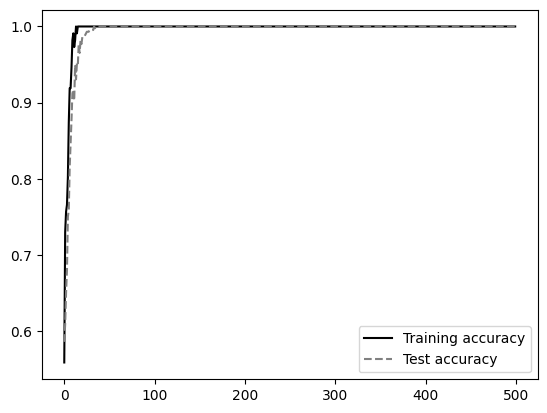

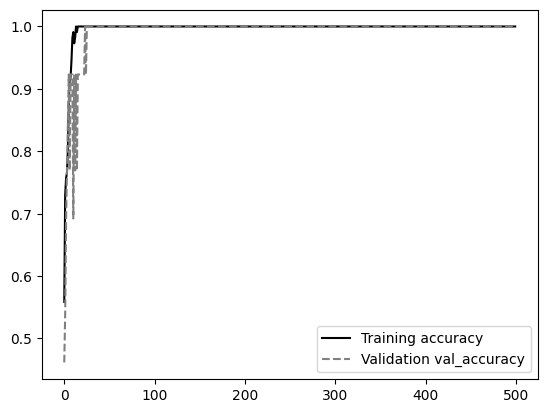

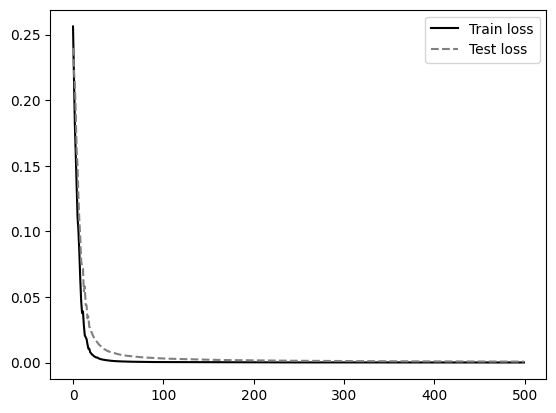

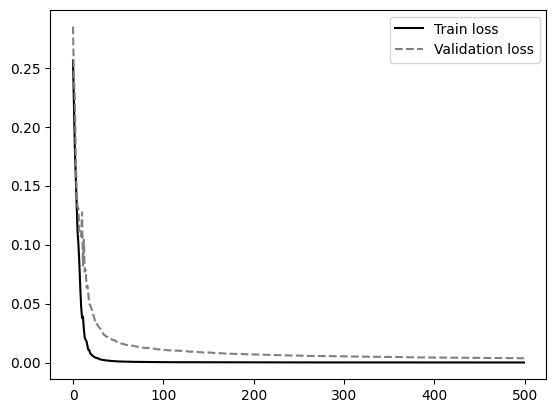

14/14 [==============================] - 0s 2ms/step - loss: 7.1702e-04 - accuracy: 1.0000
[0.0007170165772549808, 1.0]


In [10]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)

# Monks 2

In [11]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [22]:
'''params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.8],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}'''

params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.6, 0.7, 0.8, 0.9],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.6, 0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


'params = {\n    "task": "classification",\n    "trials_train": 5,\n    "trials_test": 10,\n    "initialization": {\n        "type": "uniform",\n        "min": -0.5,\n        "max": 0.5\n    },\n    "early_stopping": {\n        "monitor": "val_loss",\n        "patience": 20,\n        "delta": 0.00\n    },\n    "max_epochs": [500],\n    "learning_rate": [0.1],\n    "batch_size": [None],\n    "momentum": [0.8],\n    "nesterov": False,\n    "learning_rate_decay": None,\n    "regularization": [\n        {\n            "type": None\n        }\n    ],\n    "layers": [\n        {\n            "activations": ["relu"],\n            "units": [8],\n        },\n    ]\n}'

Testing configuration 1/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.82s/it]


Fold 1/4 mean val_loss: 0.00021064901375211775, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00012303426046855748, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.06s/it]


Fold 2/4 mean val_loss: 0.002444750163704157, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0002999414864461869, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.40s/it]


Fold 3/4 mean val_loss: 0.0010800143936648965, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00010441991616971791, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Fold 4/4 mean val_loss: 0.2634405195713043, std val_loss 0.0
Fold 4/4 mean train_loss: 0.15638864040374756, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.5952380895614624, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.8267716765403748, train_accuracy 0.0

Mean val_loss: 0.06679398328560637, std val_loss: 0.11353672329562335
Mean train_loss: 0.039229009016708005, std train_loss: 0.0676421877592754
Mean val_accuracy: 0.8988095223903656, std val_accuracy: 0.17526704846204766
Mean train_accuracy: 0.8988095223903656, std train_accuracy: 0.07501006438551165



Testing configuration 2/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.99s/it]


Fold 1/4 mean val_loss: 0.0003240454534534365, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00013383042823988944, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.52s/it]


Fold 2/4 mean val_loss: 7.811502291588113e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 7.047226245049387e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.74s/it]


Fold 3/4 mean val_loss: 0.0010913257719948888, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00016076739120762795, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.67s/it]


Fold 4/4 mean val_loss: 0.0002833942708093673, std val_loss 0.0
Fold 4/4 mean train_loss: 7.109982107067481e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0004442201297933934, std val_loss: 0.0003850602456766239
Mean train_loss: 0.00010904247574217152, std train_loss: 3.9424661906678706e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 3/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.39s/it]


Fold 1/4 mean val_loss: 0.025283344089984894, std val_loss 0.0
Fold 1/4 mean train_loss: 5.077395326225087e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9767441749572754, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Fold 2/4 mean val_loss: 8.932588389143348e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 4.6748522436246276e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.62s/it]


Fold 3/4 mean val_loss: 0.0010975656332448125, std val_loss 0.0
Fold 3/4 mean train_loss: 4.924309178022668e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.66s/it]


Fold 4/4 mean val_loss: 0.00015988880477380008, std val_loss 0.0
Fold 4/4 mean train_loss: 4.536267806543037e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.006657531102973735, std val_loss: 0.010760980446583718
Mean train_loss: 4.803206138603855e-05, std train_loss: 2.1069910550629754e-06
Mean val_accuracy: 0.9941860437393188, std val_accuracy: 0.01007006763648292
Mean train_accuracy: 0.9941860437393188, std train_accuracy: 0.0



Testing configuration 4/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.42s/it]


Fold 1/4 mean val_loss: 2.077919452858623e-05, std val_loss 0.0
Fold 1/4 mean train_loss: 1.7044278138200752e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.00s/it]


Fold 2/4 mean val_loss: 5.5464639444835484e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 1.664279625401832e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.64s/it]


Fold 3/4 mean val_loss: 8.843882096698508e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 3.884391480823979e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.53s/it]


Fold 4/4 mean val_loss: 2.6323405108996667e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 2.1511397790163755e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 4.7751515012350865e-05, std val_loss: 2.693333956579716e-05
Mean train_loss: 2.3510596747655654e-05, std train_loss: 9.056591511132379e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 5/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.67s/it]


Fold 1/4 mean val_loss: 0.00014763551007490605, std val_loss 0.0
Fold 1/4 mean train_loss: 8.619364962214604e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.55s/it]


Fold 2/4 mean val_loss: 0.00046520872274413705, std val_loss 0.0
Fold 2/4 mean train_loss: 9.299279190599918e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.25s/it]


Fold 3/4 mean val_loss: 0.00017455138731747866, std val_loss 0.0
Fold 3/4 mean train_loss: 8.521351992385462e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.12s/it]


Fold 4/4 mean val_loss: 0.00012286279525142163, std val_loss 0.0
Fold 4/4 mean train_loss: 8.35289029055275e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00022756460384698585, std val_loss: 0.00013841627173820267
Mean train_loss: 8.698221608938184e-05, std train_loss: 3.598698264382792e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 6/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.41s/it]


Fold 1/4 mean val_loss: 0.0029337957967072725, std val_loss 0.0
Fold 1/4 mean train_loss: 7.019950135145336e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.57s/it]


Fold 2/4 mean val_loss: 0.00019781070295721292, std val_loss 0.0
Fold 2/4 mean train_loss: 6.174042209750041e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.13s/it]


Fold 3/4 mean val_loss: 0.0001596924412297085, std val_loss 0.0
Fold 3/4 mean train_loss: 5.506650995812379e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Fold 4/4 mean val_loss: 0.31342050433158875, std val_loss 0.0
Fold 4/4 mean train_loss: 0.16631878912448883, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.5476190447807312, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.7716535329818726, train_accuracy 0.0

Mean val_loss: 0.07917795081812073, std val_loss: 0.1352446789535241
Mean train_loss: 0.04162644888947398, std train_loss: 0.07199115640030805
Mean val_accuracy: 0.8869047611951828, std val_accuracy: 0.19588669970407865
Mean train_accuracy: 0.8869047611951828, std train_accuracy: 0.0988769206510619



Testing configuration 7/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


Fold 1/4 mean val_loss: 0.0004128116415813565, std val_loss 0.0
Fold 1/4 mean train_loss: 8.293226710520685e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.28s/it]


Fold 2/4 mean val_loss: 7.670516788493842e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 3.667292548925616e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.91s/it]


Fold 3/4 mean val_loss: 9.948226215783507e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 3.4649598092073575e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.94s/it]


Fold 4/4 mean val_loss: 6.733844929840416e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 3.7346992030506954e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00016408438023063354, std val_loss: 0.0001440777447253916
Mean train_loss: 4.7900445679260883e-05, std train_loss: 2.0249975726723697e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 8/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Fold 1/4 mean val_loss: 0.00018840508710127324, std val_loss 0.0
Fold 1/4 mean train_loss: 1.5145124962145928e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.27s/it]


Fold 2/4 mean val_loss: 0.0018112297402694821, std val_loss 0.0
Fold 2/4 mean train_loss: 1.4333474609884433e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.91s/it]


Fold 3/4 mean val_loss: 0.023123718798160553, std val_loss 0.0
Fold 3/4 mean train_loss: 0.01578349620103836, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.976190447807312, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9842519760131836, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.99s/it]


Fold 4/4 mean val_loss: 2.6540968974586576e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 1.7564670997671783e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.006287473648626474, std val_loss: 0.009745432591727662
Mean train_loss: 0.003957634867902016, std train_loss: 0.006827664327546956
Mean val_accuracy: 0.994047611951828, std val_accuracy: 0.010309838525799642
Mean train_accuracy: 0.994047611951828, std train_accuracy: 0.006819094415994852



Testing configuration 9/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1

100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.33s/it]


Fold 1/4 mean val_loss: 0.0001604324352229014, std val_loss 0.0
Fold 1/4 mean train_loss: 9.87175153568387e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.70s/it]


Fold 2/4 mean val_loss: 0.0002469519677106291, std val_loss 0.0
Fold 2/4 mean train_loss: 6.903706525918096e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.25s/it]


Fold 3/4 mean val_loss: 9.56223375396803e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 7.425725198118016e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.34s/it]


Fold 4/4 mean val_loss: 0.0002533608640078455, std val_loss 0.0
Fold 4/4 mean train_loss: 0.00013691648200619966, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00018909190112026408, std val_loss: 6.526141892028107e-05
Mean train_loss: 9.473207865084987e-05, std train_loss: 2.6808859694769527e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 10/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.61s/it]


Fold 1/4 mean val_loss: 0.0001458411425119266, std val_loss 0.0
Fold 1/4 mean train_loss: 6.657413905486465e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.52s/it]


Fold 2/4 mean val_loss: 7.78404573793523e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 4.9478425353299826e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.42s/it]


Fold 3/4 mean val_loss: 0.00011457518121460453, std val_loss 0.0
Fold 3/4 mean train_loss: 5.109806079417467e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.86s/it]


Fold 4/4 mean val_loss: 0.00033824151614680886, std val_loss 0.0
Fold 4/4 mean train_loss: 5.227448855293915e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00016912457431317307, std val_loss: 0.00010056227486415354
Mean train_loss: 5.485627843881957e-05, std train_loss: 6.837751825451279e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 11/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.70s/it]


Fold 1/4 mean val_loss: 5.330062049324624e-05, std val_loss 0.0
Fold 1/4 mean train_loss: 2.9194063245086e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.57s/it]


Fold 2/4 mean val_loss: 5.784223321825266e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 3.141400884487666e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.51s/it]


Fold 3/4 mean val_loss: 8.844897092785686e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 4.8845609853742644e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.97s/it]


Fold 4/4 mean val_loss: 0.00020263313490431756, std val_loss 0.0
Fold 4/4 mean train_loss: 3.26219160342589e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00010055623988591833, std val_loss: 6.046457307384757e-05
Mean train_loss: 3.551889949449105e-05, std train_loss: 7.791780974131045e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 12/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.52s/it]


Fold 1/4 mean val_loss: 0.0008139676065184176, std val_loss 0.0
Fold 1/4 mean train_loss: 1.143985991802765e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.19s/it]


Fold 2/4 mean val_loss: 0.00012639867782127112, std val_loss 0.0
Fold 2/4 mean train_loss: 1.1705413271556608e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.77s/it]


Fold 3/4 mean val_loss: 0.00010086225665872917, std val_loss 0.0
Fold 3/4 mean train_loss: 3.9821672544348985e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.71s/it]


Fold 4/4 mean val_loss: 2.8844313419540413e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 1.3470609701471403e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0002675182136044896, std val_loss: 0.00031751421267821767
Mean train_loss: 1.9109388858851162e-05, std train_loss: 1.198368739709968e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 13/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.41s/it]


Fold 1/4 mean val_loss: 0.00024692073930054903, std val_loss 0.0
Fold 1/4 mean train_loss: 6.74033144605346e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.20s/it]


Fold 2/4 mean val_loss: 0.0007479138439521194, std val_loss 0.0
Fold 2/4 mean train_loss: 0.00016082904767245054, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.28s/it]


Fold 3/4 mean val_loss: 0.00017194893734995276, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00011293307761661708, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.68s/it]


Fold 4/4 mean val_loss: 0.00011998241097899154, std val_loss 0.0
Fold 4/4 mean train_loss: 0.00011793507292168215, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00032169148289540317, std val_loss: 0.00025018270563844963
Mean train_loss: 0.0001147751281678211, std train_loss: 3.3084855435445804e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 14/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.06s/it]


Fold 1/4 mean val_loss: 7.229102629935369e-05, std val_loss 0.0
Fold 1/4 mean train_loss: 4.389235618873499e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.36s/it]


Fold 2/4 mean val_loss: 0.0006432340014725924, std val_loss 0.0
Fold 2/4 mean train_loss: 4.778798029292375e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.92s/it]


Fold 3/4 mean val_loss: 0.0002512551436666399, std val_loss 0.0
Fold 3/4 mean train_loss: 4.5388380385702476e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.39s/it]


Fold 4/4 mean val_loss: 7.809757516952232e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 4.7583638661308214e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00026121943665202707, std val_loss: 0.00023198166698090085
Mean train_loss: 4.616308888216736e-05, std train_loss: 1.6135856028798493e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 15/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.65s/it]


Fold 1/4 mean val_loss: 0.011859721504151821, std val_loss 0.0
Fold 1/4 mean train_loss: 7.273612573044375e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9767441749572754, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.93s/it]


Fold 2/4 mean val_loss: 0.0005706804804503918, std val_loss 0.0
Fold 2/4 mean train_loss: 2.7446436433820054e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.76s/it]


Fold 3/4 mean val_loss: 0.00018120471213478595, std val_loss 0.0
Fold 3/4 mean train_loss: 3.5915683838538826e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.41s/it]


Fold 4/4 mean val_loss: 0.0011466601863503456, std val_loss 0.0
Fold 4/4 mean train_loss: 2.8292597562540323e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.003439566720771836, std val_loss: 0.0048734961319084015
Mean train_loss: 4.109771089133574e-05, std train_loss: 1.8561862242142646e-05
Mean val_accuracy: 0.9941860437393188, std val_accuracy: 0.01007006763648292
Mean train_accuracy: 0.9941860437393188, std train_accuracy: 0.0



Testing configuration 16/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.34s/it]


Fold 1/4 mean val_loss: 2.6345658625359647e-05, std val_loss 0.0
Fold 1/4 mean train_loss: 1.1782658475567587e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.42s/it]


Fold 2/4 mean val_loss: 0.027211995795369148, std val_loss 0.0
Fold 2/4 mean train_loss: 2.237413718830794e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9523809552192688, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.54s/it]


Fold 3/4 mean val_loss: 0.015913469716906548, std val_loss 0.0
Fold 3/4 mean train_loss: 2.5972878574975766e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.976190447807312, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.80s/it]


Fold 4/4 mean val_loss: 0.0001511310983914882, std val_loss 0.0
Fold 4/4 mean train_loss: 6.658600796072278e-06, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.010825735567323136, std val_loss: 0.01145609625926627
Mean train_loss: 1.6697068758730893e-05, std train_loss: 7.797307566875726e-06
Mean val_accuracy: 0.9821428507566452, std val_accuracy: 0.01974181529804079
Mean train_accuracy: 0.9821428507566452, std train_accuracy: 0.0






Best configuration (loss 4.7751515012350865e-05):
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:54<08:12, 54.68s/it]

Trial 1/10 val_mse: 1.7457190551795065e-05
Trial 1/10 train_mse: 1.3202496120356955e-05
Trial 1/10 test_mse: 0.0007368809310719371
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0
Trial 1/10 test_accuracy: 1.0


 20%|████████▊                                   | 2/10 [01:40<06:37, 49.67s/it]

Trial 2/10 val_mse: 3.60284248017706e-05
Trial 2/10 train_mse: 2.762679650913924e-05
Trial 2/10 test_mse: 2.8053940695826896e-05
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0
Trial 2/10 test_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [02:32<05:54, 50.58s/it]

Trial 3/10 val_mse: 2.4261507860501297e-05
Trial 3/10 train_mse: 1.2943311048729811e-05
Trial 3/10 test_mse: 1.9031424017157406e-05
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0
Trial 3/10 test_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [03:19<04:54, 49.07s/it]

Trial 4/10 val_mse: 1.274927217309596e-05
Trial 4/10 train_mse: 1.4217375792213716e-05
Trial 4/10 test_mse: 1.8837656170944683e-05
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0
Trial 4/10 test_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [04:09<04:06, 49.31s/it]

Trial 5/10 val_mse: 9.701679118734319e-06
Trial 5/10 train_mse: 1.3453064639179502e-05
Trial 5/10 test_mse: 1.8411285054753534e-05
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0
Trial 5/10 test_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [04:56<03:14, 48.70s/it]

Trial 6/10 val_mse: 1.4792920410400257e-05
Trial 6/10 train_mse: 1.5108545994735323e-05
Trial 6/10 test_mse: 7.804882625350729e-05
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0
Trial 6/10 test_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [05:44<02:25, 48.35s/it]

Trial 7/10 val_mse: 1.3946778381068725e-05
Trial 7/10 train_mse: 1.3621121070173103e-05
Trial 7/10 test_mse: 1.9069477275479585e-05
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0
Trial 7/10 test_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [06:31<01:36, 48.04s/it]

Trial 8/10 val_mse: 1.521704689366743e-05
Trial 8/10 train_mse: 1.3029457477387041e-05
Trial 8/10 test_mse: 1.5700059520895593e-05
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0
Trial 8/10 test_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [07:20<00:48, 48.40s/it]

Trial 9/10 val_mse: 2.4691044018254615e-05
Trial 9/10 train_mse: 1.3633706657856237e-05
Trial 9/10 test_mse: 3.886714330292307e-05
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0
Trial 9/10 test_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [08:13<00:00, 49.38s/it]

Trial 10/10 val_mse: 1.3925759049016051e-05
Trial 10/10 train_mse: 1.3034634321229532e-05
Trial 10/10 test_mse: 0.00012463163875509053
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0
Trial 10/10 test_accuracy: 1.0

Median val_mse: 1.521704689366743e-05, std val_mse: 7.456658826770171e-06
Median train_mse: 1.3029457477387041e-05, std train_mse: 4.259417325480304e-06
Median val_accuracy: 1.0, std val_accuracy: 0.0
Median train_accuracy: 1.0, std train_accuracy: 0.0


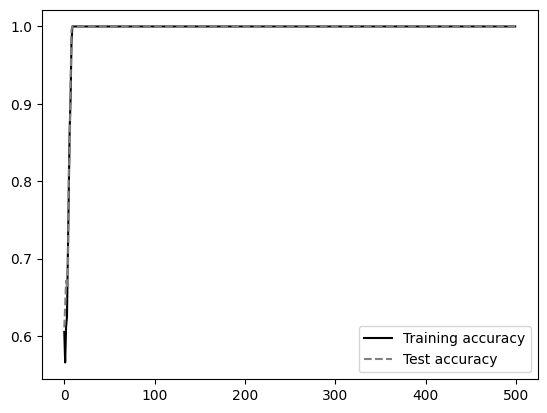

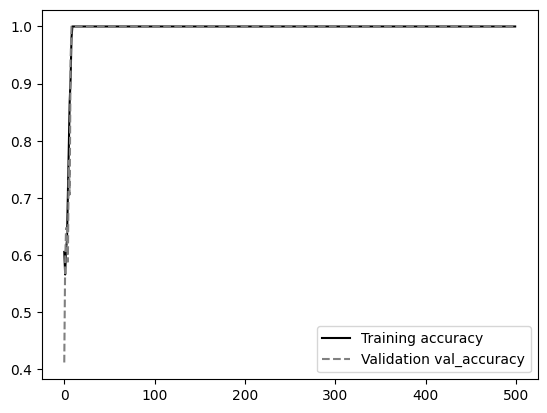

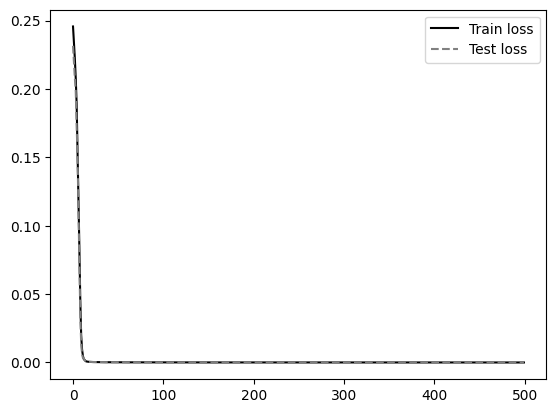

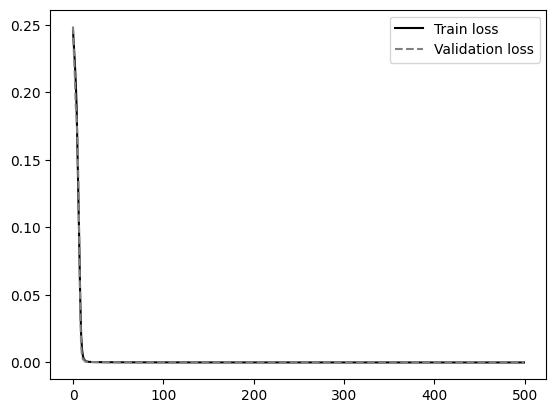

14/14 [==============================] - 0s 2ms/step - loss: 1.5700e-05 - accuracy: 1.0000
[1.5700059520895593e-05, 1.0]


In [12]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)

# Monks 3

In [13]:
'''params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": np.linspace(0.1, 0.9, 5).tolist(),
    "batch_size": [None],
    "momentum": np.linspace(0.5, 0.99, 5).tolist(),
    "nesterov": False,
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l2",
            "value": [0.000001, 0.00001, 0.0001, 0.001, 0.01],
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}'''

params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.6, 0.7, 0.8, 0.9],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.6, 0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [14]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


Testing configuration 1/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


Fold 1/5 mean val_loss: 0.07323234528303146, std val_loss 0.0
Fold 1/5 mean train_loss: 0.04277082160115242, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.9587628841400146, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


Fold 2/5 mean val_loss: 0.04080456867814064, std val_loss 0.0
Fold 2/5 mean train_loss: 0.05469194054603577, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.9599999785423279, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.938144326210022, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


Fold 3/5 mean val_loss: 0.0744195207953453, std val_loss 0.0
Fold 3/5 mean train_loss: 0.03372582793235779, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


Fold 4/5 mean val_loss: 0.04395372048020363, std val_loss 0.0
Fold 4/5 mean train_loss: 0.03469203785061836, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]


Fold 5/5 mean val_loss: 0.13414853811264038, std val_loss 0.0
Fold 5/5 mean train_loss: 0.03092694841325283, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Mean val_loss: 0.07331173866987228, std val_loss: 0.033528969515579314
Mean train_loss: 0.039361515268683436, std train_loss: 0.008618030146181501
Mean val_accuracy: 0.9176666617393494, std val_accuracy: 0.0459661710413236
Mean train_accuracy: 0.9176666617393494, std train_accuracy: 0.007752251311486479



Testing configuration 2/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Fold 1/5 mean val_loss: 0.10818824172019958, std val_loss 0.0
Fold 1/5 mean train_loss: 0.039900876581668854, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.9587628841400146, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Fold 2/5 mean val_loss: 0.142128586769104, std val_loss 0.0
Fold 2/5 mean train_loss: 0.006587163079530001, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Fold 3/5 mean val_loss: 0.00960705429315567, std val_loss 0.0
Fold 3/5 mean train_loss: 0.02227434143424034, std train_loss 0.0
Fold 3/5 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9795918464660645, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


Fold 4/5 mean val_loss: 0.05995820462703705, std val_loss 0.0
Fold 4/5 mean train_loss: 0.02135552652180195, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9897959232330322, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Fold 5/5 mean val_loss: 0.09431076049804688, std val_loss 0.0
Fold 5/5 mean train_loss: 0.06950392574071884, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9081632494926453, train_accuracy 0.0

Mean val_loss: 0.08283856958150863, std val_loss: 0.04511294517529988
Mean train_loss: 0.031924366671592, std train_loss: 0.021552935879988532
Mean val_accuracy: 0.8866666674613952, std val_accuracy: 0.08141115637125343
Mean train_accuracy: 0.8866666674613952, std train_accuracy: 0.032546817764671644



Testing configuration 3/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Fold 1/5 mean val_loss: 0.013203540816903114, std val_loss 0.0
Fold 1/5 mean train_loss: 0.024142349138855934, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9599999785423279, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.9793814420700073, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Fold 2/5 mean val_loss: 0.16052226722240448, std val_loss 0.0
Fold 2/5 mean train_loss: 0.02288336306810379, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.8399999737739563, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.969072163105011, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Fold 3/5 mean val_loss: 0.22216714918613434, std val_loss 0.0
Fold 3/5 mean train_loss: 0.023815980181097984, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.75, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9795918464660645, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


Fold 4/5 mean val_loss: 0.0011870893649756908, std val_loss 0.0
Fold 4/5 mean train_loss: 0.04813133552670479, std train_loss 0.0
Fold 4/5 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9387755393981934, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]


Fold 5/5 mean val_loss: 0.03224438056349754, std val_loss 0.0
Fold 5/5 mean train_loss: 0.04000811278820038, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Mean val_loss: 0.08586488543078304, std val_loss: 0.08885627771935459
Mean train_loss: 0.031796228140592575, std train_loss: 0.010353513102807835
Mean val_accuracy: 0.9016666531562805, std val_accuracy: 0.09283198518647416
Mean train_accuracy: 0.9016666531562805, std train_accuracy: 0.016515324024468016



Testing configuration 4/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Fold 1/5 mean val_loss: 0.0500972643494606, std val_loss 0.0
Fold 1/5 mean train_loss: 0.06099986657500267, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.938144326210022, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Fold 2/5 mean val_loss: 0.1885996013879776, std val_loss 0.0
Fold 2/5 mean train_loss: 0.016022654250264168, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.9793814420700073, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


Fold 3/5 mean val_loss: 0.12221157550811768, std val_loss 0.0
Fold 3/5 mean train_loss: 0.03204559162259102, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9693877696990967, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


Fold 4/5 mean val_loss: 0.0008640701416879892, std val_loss 0.0
Fold 4/5 mean train_loss: 0.0480155311524868, std train_loss 0.0
Fold 4/5 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9387755393981934, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.49s/it]


Fold 5/5 mean val_loss: 0.00036677331081591547, std val_loss 0.0
Fold 5/5 mean train_loss: 0.03071744181215763, std train_loss 0.0
Fold 5/5 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9693877696990967, train_accuracy 0.0

Mean val_loss: 0.07242785693961196, std val_loss: 0.0731944308847701
Mean train_loss: 0.03756021708250046, std train_loss: 0.015490849174589729
Mean val_accuracy: 0.9190000057220459, std val_accuracy: 0.07644605574677843
Mean train_accuracy: 0.9190000057220459, std train_accuracy: 0.017176736909374733



Testing configuration 5/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executi

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Fold 1/5 mean val_loss: 0.11441046744585037, std val_loss 0.0
Fold 1/5 mean train_loss: 0.09299419075250626, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.8399999737739563, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.8659793734550476, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Fold 2/5 mean val_loss: 0.24790340662002563, std val_loss 0.0
Fold 2/5 mean train_loss: 0.11650095134973526, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.6800000071525574, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.8350515365600586, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


Fold 3/5 mean val_loss: 0.06118154153227806, std val_loss 0.0
Fold 3/5 mean train_loss: 0.03228713944554329, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9693877696990967, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


Fold 4/5 mean val_loss: 0.04198603332042694, std val_loss 0.0
Fold 4/5 mean train_loss: 0.04389810562133789, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Fold 5/5 mean val_loss: 0.10836199671030045, std val_loss 0.0
Fold 5/5 mean train_loss: 0.007559996098279953, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.11476868912577629, std val_loss: 0.07202072535880125
Mean train_loss: 0.05864807665348053, std train_loss: 0.040122470749116054
Mean val_accuracy: 0.8539999961853028, std val_accuracy: 0.0956300707362613
Mean train_accuracy: 0.8539999961853028, std train_accuracy: 0.06283021678371432



Testing configuration 6/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


Fold 1/5 mean val_loss: 0.07501231878995895, std val_loss 0.0
Fold 1/5 mean train_loss: 0.02606324478983879, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.9793814420700073, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Fold 2/5 mean val_loss: 0.04154015704989433, std val_loss 0.0
Fold 2/5 mean train_loss: 0.060425881296396255, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.9599999785423279, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.9278350472450256, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Fold 3/5 mean val_loss: 0.04947589337825775, std val_loss 0.0
Fold 3/5 mean train_loss: 0.03724085912108421, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Fold 4/5 mean val_loss: 0.10335930436849594, std val_loss 0.0
Fold 4/5 mean train_loss: 0.02755015157163143, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9795918464660645, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


Fold 5/5 mean val_loss: 0.10817018896341324, std val_loss 0.0
Fold 5/5 mean train_loss: 0.01802120916545391, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9897959232330322, train_accuracy 0.0

Mean val_loss: 0.07551157251000404, std val_loss: 0.027108095871178278
Mean train_loss: 0.03386026918888092, std train_loss: 0.014619487892434425
Mean val_accuracy: 0.9259999990463257, std val_accuracy: 0.03138646918810458
Mean train_accuracy: 0.9259999990463257, std train_accuracy: 0.023118840359025995



Testing configuration 7/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Fold 1/5 mean val_loss: 0.057568445801734924, std val_loss 0.0
Fold 1/5 mean train_loss: 0.037061695009469986, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.969072163105011, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Fold 2/5 mean val_loss: 0.11452729254961014, std val_loss 0.0
Fold 2/5 mean train_loss: 0.04181484505534172, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.9587628841400146, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


Fold 3/5 mean val_loss: 0.04182508960366249, std val_loss 0.0
Fold 3/5 mean train_loss: 0.04451245069503784, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


Fold 4/5 mean val_loss: 0.07733872532844543, std val_loss 0.0
Fold 4/5 mean train_loss: 0.02613798901438713, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


Fold 5/5 mean val_loss: 0.13466860353946686, std val_loss 0.0
Fold 5/5 mean train_loss: 0.02827937714755535, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.7916666865348816, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9795918464660645, train_accuracy 0.0

Mean val_loss: 0.08518563136458397, std val_loss: 0.0346811680048713
Mean train_loss: 0.035561271384358405, std train_loss: 0.007256807839061763
Mean val_accuracy: 0.8933333396911621, std val_accuracy: 0.056558712443165446
Mean train_accuracy: 0.8933333396911621, std train_accuracy: 0.010403647239115152



Testing configuration 8/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Fold 1/5 mean val_loss: 0.05967095494270325, std val_loss 0.0
Fold 1/5 mean train_loss: 0.054556723684072495, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.938144326210022, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


Fold 2/5 mean val_loss: 0.11675617843866348, std val_loss 0.0
Fold 2/5 mean train_loss: 0.03722862899303436, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.969072163105011, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Fold 3/5 mean val_loss: 0.04141427204012871, std val_loss 0.0
Fold 3/5 mean train_loss: 0.07276330888271332, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9285714030265808, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Fold 4/5 mean val_loss: 0.0835329219698906, std val_loss 0.0
Fold 4/5 mean train_loss: 0.05771104618906975, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9285714030265808, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Fold 5/5 mean val_loss: 0.08339006453752518, std val_loss 0.0
Fold 5/5 mean train_loss: 0.03575070574879646, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Mean val_loss: 0.07695287838578224, std val_loss: 0.025419262196627268
Mean train_loss: 0.051602082699537276, std train_loss: 0.013796442690251213
Mean val_accuracy: 0.9100000023841858, std val_accuracy: 0.030349808960717848
Mean train_accuracy: 0.9100000023841858, std train_accuracy: 0.01653492948441719



Testing configuration 9/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Fold 1/5 mean val_loss: 0.1139303520321846, std val_loss 0.0
Fold 1/5 mean train_loss: 0.08006870001554489, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.9175257682800293, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Fold 2/5 mean val_loss: 0.08051276952028275, std val_loss 0.0
Fold 2/5 mean train_loss: 0.04532071202993393, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.9484536051750183, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Fold 3/5 mean val_loss: 0.05533931031823158, std val_loss 0.0
Fold 3/5 mean train_loss: 0.02503407560288906, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9795918464660645, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Fold 4/5 mean val_loss: 0.10193931311368942, std val_loss 0.0
Fold 4/5 mean train_loss: 0.08089813590049744, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.8877550959587097, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Fold 5/5 mean val_loss: 0.10059317946434021, std val_loss 0.0
Fold 5/5 mean train_loss: 0.03139370679855347, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Mean val_loss: 0.09046298488974572, std val_loss: 0.020580202008363167
Mean train_loss: 0.05254306606948376, std train_loss: 0.02373972561420582
Mean val_accuracy: 0.8693333387374877, std val_accuracy: 0.03801461740344866
Mean train_accuracy: 0.8693333387374877, std train_accuracy: 0.03234313812124261



Testing configuration 10/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executi

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


Fold 1/5 mean val_loss: 0.06211316958069801, std val_loss 0.0
Fold 1/5 mean train_loss: 0.03771251067519188, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.969072163105011, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Fold 2/5 mean val_loss: 0.0513308010995388, std val_loss 0.0
Fold 2/5 mean train_loss: 0.04423896595835686, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.9587628841400146, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Fold 3/5 mean val_loss: 0.1347760707139969, std val_loss 0.0
Fold 3/5 mean train_loss: 0.01307419128715992, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.7916666865348816, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9795918464660645, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


Fold 4/5 mean val_loss: 0.020590756088495255, std val_loss 0.0
Fold 4/5 mean train_loss: 0.01909148134291172, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9897959232330322, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Fold 5/5 mean val_loss: 0.14142891764640808, std val_loss 0.0
Fold 5/5 mean train_loss: 0.04594261944293976, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Mean val_loss: 0.08204794302582741, std val_loss: 0.047800166156758354
Mean train_loss: 0.03201195374131203, std train_loss: 0.013428604378492902
Mean val_accuracy: 0.8846666693687439, std val_accuracy: 0.061980280014854804
Mean train_accuracy: 0.8846666693687439, std train_accuracy: 0.011998329669238736



Testing configuration 11/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Fold 1/5 mean val_loss: 0.07375969737768173, std val_loss 0.0
Fold 1/5 mean train_loss: 0.0352502278983593, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.969072163105011, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Fold 2/5 mean val_loss: 0.0830986425280571, std val_loss 0.0
Fold 2/5 mean train_loss: 0.03543572500348091, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.9587628841400146, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


Fold 3/5 mean val_loss: 0.03502264246344566, std val_loss 0.0
Fold 3/5 mean train_loss: 0.036084529012441635, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


Fold 4/5 mean val_loss: 0.11451059579849243, std val_loss 0.0
Fold 4/5 mean train_loss: 0.009128430858254433, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9897959232330322, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Fold 5/5 mean val_loss: 0.06602013856172562, std val_loss 0.0
Fold 5/5 mean train_loss: 0.06132309138774872, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.8979591727256775, train_accuracy 0.0

Mean val_loss: 0.07448234334588051, std val_loss: 0.02571264563106009
Mean train_loss: 0.035444400832057, std train_loss: 0.016508691305035846
Mean val_accuracy: 0.9013333320617676, std val_accuracy: 0.043042618453272195
Mean train_accuracy: 0.9013333320617676, std train_accuracy: 0.030640138308483632



Testing configuration 12/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1'

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Fold 1/5 mean val_loss: 0.07787785679101944, std val_loss 0.0
Fold 1/5 mean train_loss: 0.061852727085351944, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.938144326210022, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Fold 2/5 mean val_loss: 0.07972387224435806, std val_loss 0.0
Fold 2/5 mean train_loss: 0.06343957781791687, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.9200000166893005, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.938144326210022, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Fold 3/5 mean val_loss: 0.1373763531446457, std val_loss 0.0
Fold 3/5 mean train_loss: 0.04962052032351494, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9387755393981934, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Fold 4/5 mean val_loss: 0.07918021827936172, std val_loss 0.0
Fold 4/5 mean train_loss: 0.03264976665377617, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


Fold 5/5 mean val_loss: 0.08332765847444534, std val_loss 0.0
Fold 5/5 mean train_loss: 0.061220746487379074, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9387755393981934, train_accuracy 0.0

Mean val_loss: 0.09149719178676605, std val_loss: 0.023010623184084294
Mean train_loss: 0.0537566676735878, std train_loss: 0.011641532415984533
Mean val_accuracy: 0.9013333439826965, std val_accuracy: 0.03403267923013938
Mean train_accuracy: 0.9013333439826965, std train_accuracy: 0.008294309099182785



Testing configuration 13/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


Fold 1/5 mean val_loss: 0.1278454065322876, std val_loss 0.0
Fold 1/5 mean train_loss: 0.07463289052248001, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.9278350472450256, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Fold 2/5 mean val_loss: 0.11372113227844238, std val_loss 0.0
Fold 2/5 mean train_loss: 0.028976619243621826, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.8399999737739563, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.9793814420700073, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 3/5 mean val_loss: 0.08745879679918289, std val_loss 0.0
Fold 3/5 mean train_loss: 0.03246276080608368, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9693877696990967, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]


Fold 4/5 mean val_loss: 0.04296265169978142, std val_loss 0.0
Fold 4/5 mean train_loss: 0.05093967169523239, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Fold 5/5 mean val_loss: 0.0181667972356081, std val_loss 0.0
Fold 5/5 mean train_loss: 0.048105638474226, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.9583333134651184, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.918367326259613, train_accuracy 0.0

Mean val_loss: 0.07803095690906048, std val_loss: 0.04161167100181343
Mean train_loss: 0.04702351614832878, std train_loss: 0.016226465421364127
Mean val_accuracy: 0.9106666564941406, std val_accuracy: 0.045857267458348165
Mean train_accuracy: 0.9106666564941406, std train_accuracy: 0.023344333449376004



Testing configuration 14/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


Fold 1/5 mean val_loss: 0.12023112177848816, std val_loss 0.0
Fold 1/5 mean train_loss: 0.029993785545229912, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.969072163105011, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Fold 2/5 mean val_loss: 0.05020187050104141, std val_loss 0.0
Fold 2/5 mean train_loss: 0.09408678114414215, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.9599999785423279, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.876288652420044, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


Fold 3/5 mean val_loss: 0.1226108968257904, std val_loss 0.0
Fold 3/5 mean train_loss: 0.031606025993824005, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9693877696990967, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


Fold 4/5 mean val_loss: 0.12125813215970993, std val_loss 0.0
Fold 4/5 mean train_loss: 0.03304362669587135, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


Fold 5/5 mean val_loss: 0.011206593364477158, std val_loss 0.0
Fold 5/5 mean train_loss: 0.034497134387493134, std train_loss 0.0
Fold 5/5 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9387755393981934, train_accuracy 0.0

Mean val_loss: 0.08510172292590142, std val_loss: 0.04610160212238953
Mean train_loss: 0.044645470753312114, std train_loss: 0.02476583811932014
Mean val_accuracy: 0.9013333201408387, std val_accuracy: 0.067646142668899
Mean train_accuracy: 0.9013333201408387, std train_accuracy: 0.034943334525558686



Testing configuration 15/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executin

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


Fold 1/5 mean val_loss: 0.0052567338570952415, std val_loss 0.0
Fold 1/5 mean train_loss: 0.07058204710483551, std train_loss 0.0
Fold 1/5 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.9175257682800293, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Fold 2/5 mean val_loss: 0.10387835651636124, std val_loss 0.0
Fold 2/5 mean train_loss: 0.04206438735127449, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.938144326210022, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]


Fold 3/5 mean val_loss: 0.08245819061994553, std val_loss 0.0
Fold 3/5 mean train_loss: 0.09740200638771057, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.8877550959587097, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


Fold 4/5 mean val_loss: 0.0826011672616005, std val_loss 0.0
Fold 4/5 mean train_loss: 0.040358029305934906, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Fold 5/5 mean val_loss: 0.12484737485647202, std val_loss 0.0
Fold 5/5 mean train_loss: 0.051205508410930634, std train_loss 0.0
Fold 5/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Mean val_loss: 0.0798083646222949, std val_loss: 0.04044908880754999
Mean train_loss: 0.060322395712137225, std train_loss: 0.02142524867496816
Mean val_accuracy: 0.9176666736602783, std val_accuracy: 0.044766059196103096
Mean train_accuracy: 0.9176666736602783, std train_accuracy: 0.025369184143951787



Testing configuration 16/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Fold 1/5 mean val_loss: 0.0810987576842308, std val_loss 0.0
Fold 1/5 mean train_loss: 0.03501797094941139, std train_loss 0.0
Fold 1/5 mean val_accuracy: 0.8799999952316284, std val_accuracy 0.0
Fold 1/5 mean train_accuracy: 0.969072163105011, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


Fold 2/5 mean val_loss: 0.145436629652977, std val_loss 0.0
Fold 2/5 mean train_loss: 0.022394340485334396, std train_loss 0.0
Fold 2/5 mean val_accuracy: 0.8399999737739563, std val_accuracy 0.0
Fold 2/5 mean train_accuracy: 0.9793814420700073, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Fold 3/5 mean val_loss: 0.12413543462753296, std val_loss 0.0
Fold 3/5 mean train_loss: 0.03431672602891922, std train_loss 0.0
Fold 3/5 mean val_accuracy: 0.875, std val_accuracy 0.0
Fold 3/5 mean train_accuracy: 0.9591836929321289, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Fold 4/5 mean val_loss: 0.0832483097910881, std val_loss 0.0
Fold 4/5 mean train_loss: 0.061227623373270035, std train_loss 0.0
Fold 4/5 mean val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 4/5 mean train_accuracy: 0.9387755393981934, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Fold 5/5 mean val_loss: 0.005504576489329338, std val_loss 0.0
Fold 5/5 mean train_loss: 0.05318502336740494, std train_loss 0.0
Fold 5/5 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 mean train_accuracy: 0.9489796161651611, train_accuracy 0.0

Mean val_loss: 0.08788474164903164, std val_loss: 0.047917366882423644
Mean train_loss: 0.041228336840868, std train_loss: 0.014028487029903513
Mean val_accuracy: 0.9023333311080932, std val_accuracy: 0.05454458654644445
Mean train_accuracy: 0.9023333311080932, std train_accuracy: 0.014326838370102136






Best configuration (loss 0.07242785693961196):
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'u

 10%|████▍                                       | 1/10 [00:02<00:26,  2.92s/it]

Trial 1/10 val_mse: 0.16336935758590698
Trial 1/10 train_mse: 0.020233923569321632
Trial 1/10 test_mse: 0.057915475219488144
Trial 1/10 val_accuracy: 0.8461538553237915
Trial 1/10 train_accuracy: 0.9816513657569885
Trial 1/10 test_accuracy: 0.9282407164573669


 20%|████████▊                                   | 2/10 [00:07<00:32,  4.09s/it]

Trial 2/10 val_mse: 0.1539270281791687
Trial 2/10 train_mse: 0.021876173093914986
Trial 2/10 test_mse: 0.06309165805578232
Trial 2/10 val_accuracy: 0.8461538553237915
Trial 2/10 train_accuracy: 0.963302731513977
Trial 2/10 test_accuracy: 0.9282407164573669


 30%|█████████████▏                              | 3/10 [00:11<00:28,  4.07s/it]

Trial 3/10 val_mse: 0.15709544718265533
Trial 3/10 train_mse: 0.020294945687055588
Trial 3/10 test_mse: 0.06501604616641998
Trial 3/10 val_accuracy: 0.8461538553237915
Trial 3/10 train_accuracy: 0.9724770784378052
Trial 3/10 test_accuracy: 0.9259259104728699


 40%|█████████████████▌                          | 4/10 [00:14<00:21,  3.63s/it]

Trial 4/10 val_mse: 0.15060926973819733
Trial 4/10 train_mse: 0.05346611142158508
Trial 4/10 test_mse: 0.029878044500947
Trial 4/10 val_accuracy: 0.8461538553237915
Trial 4/10 train_accuracy: 0.9449541568756104
Trial 4/10 test_accuracy: 0.9675925970077515


 50%|██████████████████████                      | 5/10 [00:17<00:17,  3.44s/it]

Trial 5/10 val_mse: 0.1554526388645172
Trial 5/10 train_mse: 0.021512290462851524
Trial 5/10 test_mse: 0.0464700423181057
Trial 5/10 val_accuracy: 0.8461538553237915
Trial 5/10 train_accuracy: 0.9724770784378052
Trial 5/10 test_accuracy: 0.9537037014961243


 60%|██████████████████████████▍                 | 6/10 [00:20<00:13,  3.30s/it]

Trial 6/10 val_mse: 0.17507031559944153
Trial 6/10 train_mse: 0.026962116360664368
Trial 6/10 test_mse: 0.07600940018892288
Trial 6/10 val_accuracy: 0.7692307829856873
Trial 6/10 train_accuracy: 0.963302731513977
Trial 6/10 test_accuracy: 0.9097222089767456


 70%|██████████████████████████████▊             | 7/10 [00:23<00:09,  3.16s/it]

Trial 7/10 val_mse: 0.1696026623249054
Trial 7/10 train_mse: 0.016381148248910904
Trial 7/10 test_mse: 0.061172183603048325
Trial 7/10 val_accuracy: 0.8461538553237915
Trial 7/10 train_accuracy: 0.9816513657569885
Trial 7/10 test_accuracy: 0.9328703880310059


 80%|███████████████████████████████████▏        | 8/10 [00:27<00:06,  3.17s/it]

Trial 8/10 val_mse: 0.15660841763019562
Trial 8/10 train_mse: 0.017680596560239792
Trial 8/10 test_mse: 0.054495904594659805
Trial 8/10 val_accuracy: 0.8461538553237915
Trial 8/10 train_accuracy: 0.9908257126808167
Trial 8/10 test_accuracy: 0.9375


 90%|███████████████████████████████████████▌    | 9/10 [00:30<00:03,  3.33s/it]

Trial 9/10 val_mse: 0.15601883828639984
Trial 9/10 train_mse: 0.02056436613202095
Trial 9/10 test_mse: 0.0691390112042427
Trial 9/10 val_accuracy: 0.8461538553237915
Trial 9/10 train_accuracy: 0.9724770784378052
Trial 9/10 test_accuracy: 0.9236111044883728


100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.40s/it]

Trial 10/10 val_mse: 0.15374095737934113
Trial 10/10 train_mse: 0.03075513243675232
Trial 10/10 test_mse: 0.043145131319761276
Trial 10/10 val_accuracy: 0.8461538553237915
Trial 10/10 train_accuracy: 0.9541284441947937
Trial 10/10 test_accuracy: 0.9513888955116272

Median val_mse: 0.15660841763019562, std val_mse: 0.007376681541975463
Median train_mse: 0.017680596560239792, std train_mse: 0.010303358864244477
Median val_accuracy: 0.8461538553237915, std val_accuracy: 0.023076921701431274
Median train_accuracy: 0.9908257126808167, std train_accuracy: 0.013006831165748413


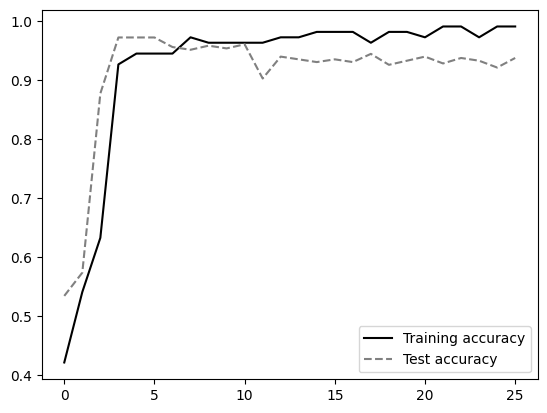

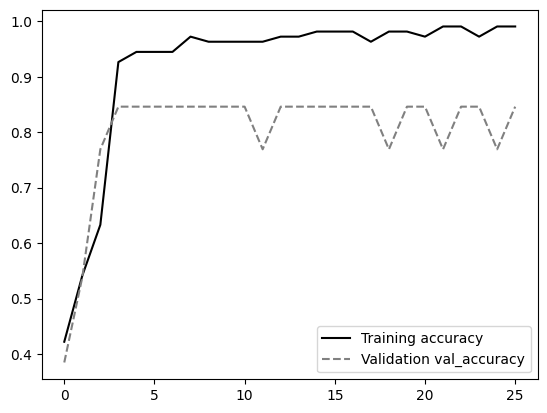

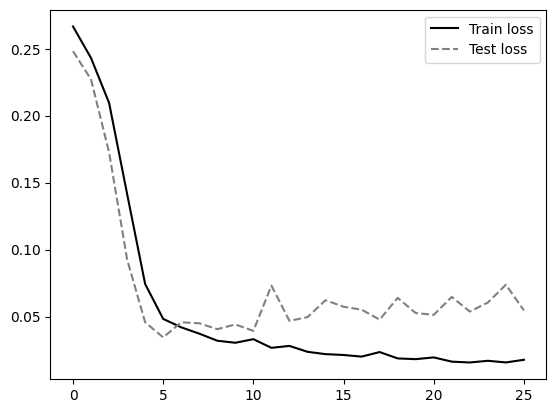

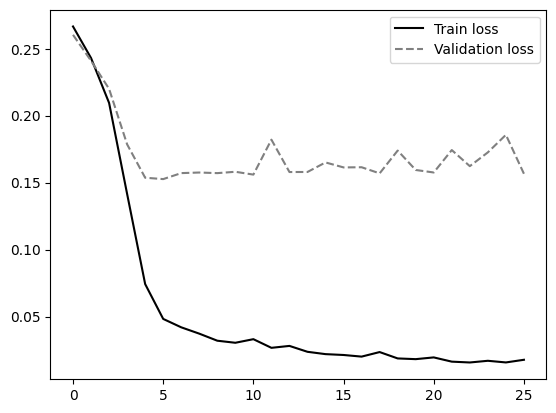

14/14 [==============================] - 0s 2ms/step - loss: 0.0545 - accuracy: 0.9375
[0.054495904594659805, 0.9375]


In [15]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)